# Figure 2 - SARS-CoV Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path as P

C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [2]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6) #todo make bigger

## Load Data

### UMAPs

In [5]:
path_ad = '../results/fig2_haniffa_lv.h5ad'
adata = sc.read(path_ad)

In [6]:
adata.obs['Specificity_IEDB'] = adata.obs['Specificity_IEDB'].astype(str)
adata.obs.loc[adata.obs['Specificity_IEDB'].isna() & ~adata.obs['leiden_moe_cd8te'].isna(),
              'Specificity_IEDB'] = 'No Match' 

In [7]:
dict_rename = {
    'v_gene_alpha': 'IR_VJ_1_v_call',
    'j_gene_alpha': 'IR_VJ_1_j_call',
    'v_gene_beta': 'IR_VDJ_1_v_call',
    'd_gene_beta': 'IR_VDJ_1_d_call',
    'j_gene_beta': 'IR_VDJ_1_j_call',
}
adata.obs = adata.obs.rename(columns=dict_rename)

In [8]:
df_comp = adata.uns['cluster_comparisson']
df_comp['model'] = df_comp['model'].replace({'moe': 'mvTCR', 'rna': 'RNA', 'tcr': 'TCR'})


In [9]:
palette_leiden_moe = adata.uns['leiden_moe_cd8te_colors']
palette_leiden_moe = dict(zip(adata.obs['leiden_moe_cd8te'].value_counts().index, palette_leiden_moe))
palette_leiden_moe['-99'] = 'lightgray'

In [10]:
palette_leiden_rna = reversed(adata.uns['leiden_rna_cd8te_colors'])
palette_leiden_rna = dict(zip(adata.obs['leiden_rna_cd8te'].value_counts().index, palette_leiden_rna))
palette_leiden_rna['-99'] = 'lightgray'

In [11]:
#sc.tl.rank_genes_groups(adata, groupby='Site', key_added='deg_test', n_genes=20)

In [12]:
def transform_status(name):
    if 'LPS' in name: 
        return 'LPS'
    return name

adata.obs['Status_on_day_collection_summary'] = adata.obs['Status_on_day_collection_summary'].apply(transform_status)

In [13]:
cp_ct = sb.color_palette('pastel')
cp_ct2 = sb.color_palette('bright')

palette_celltype = {
    'CD8.TE': cp_ct[3],
    'CD4.IL22': cp_ct[0],
    'CD8.Naive': cp_ct[1],
    'CD4.Naive': cp_ct[2],
    'CD8.EM': cp_ct[4],
    'CD4.CM': cp_ct[5],
    'CD4.Tfh': cp_ct[6],
    'CD4.EM': cp_ct[7],
    'CD8.Prolif': cp_ct2[0],
    'Treg': cp_ct2[1],
    'CD4.Th1': cp_ct2[2],
    'CD4.Prolif': cp_ct2[4],
    'CD4.Th2': cp_ct2[5],
    'CD4.Th17': cp_ct2[6],
}


cp_st = sb.color_palette('deep')
palette_status = {
    'Healthy': cp_st[2],
    'Asymptomatic': cp_st[8],
    'Mild': cp_st[1],
    'Moderate': cp_st[6],
    'Severe': cp_st[3],
    'Critical': cp_st[5],
    'Non_covid': cp_st[9],
    'LPS': cp_st[0],
}
order_status = palette_status.keys()
order_ct = ['CD8.Naive', 'CD8.Prolif', 'CD8.EM', 'CD8.TE', 
            'CD4.Naive', 'CD4.Prolif', 'CD4.CM', 'CD4.EM', 
            'CD4.IL22', 'CD4.Tfh', 'CD4.Th1', 'CD4.Th2', 'CD4.Th17', 'Treg']


In [14]:
palette_query = {
    'SARS-CoV': 'tab:red', 
    'Influenza': 'tab:blue', 
    'Human Herpesvirus': 'tab:green', 
    'Yellow Fever': 'tab:purple', 
    'Others': 'tab:olive',
    'No Match': 'darkgrey',
    '-99': 'lightgrey',
    'nan': 'lightgrey' 
}

In [15]:
color_covid_clusters = 'maroon'
color_bystander_clusters = 'navy'

In [16]:
react_leiden_moe = adata.uns['moe_reactiveClusters']
df_status_moe = adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden_moe)].obs[['leiden_moe_cd8te', 
                                                                         'Status_on_day_collection_summary']]
df_status_moe = df_status_moe.value_counts().unstack()
df_status_moe.head()

Status_on_day_collection_summary,Asymptomatic,Critical,Healthy,LPS,Mild,Moderate,Non_covid,Severe
leiden_moe_cd8te,,,,,,,,
3,1.0,62.0,NaN,1.0,27.0,834.0,NaN,154.0
8,NaN,60.0,2.0,1.0,26.0,518.0,33.0,133.0
12,NaN,9.0,2.0,NaN,29.0,47.0,NaN,605.0
13,1.0,1.0,3.0,1.0,3.0,652.0,1.0,5.0
14,NaN,32.0,4.0,1.0,139.0,220.0,1.0,213.0


In [17]:
react_leiden_rna = adata.uns['rna_reactiveClusters']
df_status_rna = adata[adata.obs['leiden_rna_cd8te'].isin(react_leiden_rna)].obs[['leiden_rna_cd8te', 
                                                                         'Status_on_day_collection_summary']]
df_status_rna = df_status_rna.value_counts().unstack()
df_status_rna.head()

Status_on_day_collection_summary,Asymptomatic,Critical,Healthy,LPS,Mild,Moderate,Non_covid,Severe
leiden_rna_cd8te,,,,,,,,
2,NaN,129.0,1.0,NaN,36.0,435.0,1.0,100.0
4,NaN,15.0,NaN,NaN,35.0,162.0,NaN,458.0
6,2.0,4.0,NaN,NaN,415.0,106.0,6.0,61.0
10,NaN,11.0,3.0,NaN,14.0,430.0,NaN,36.0
16,NaN,7.0,NaN,NaN,31.0,258.0,NaN,164.0


In [18]:
df_status_tcr = adata.obs[~adata.obs['leiden_moe_cd8te'].isna()][['Specificity_IEDB', 'Status_on_day_collection_summary']
                                                                ].copy()
df_status_tcr['Specificity_IEDB'] = df_status_tcr['Specificity_IEDB'].astype(str)
df_status_tcr.loc[df_status_tcr['Specificity_IEDB'].isna(), 'Specificity_IEDB'] = 'No match'
df_status_tcr['Group'] = df_status_tcr['Specificity_IEDB'].apply(lambda x: x if x in ['SARS-CoV', 'No Match']
                                                                else 'Bystander')
df_status_tcr = df_status_tcr[['Status_on_day_collection_summary', 'Group']]
df_status_tcr = df_status_tcr.value_counts().unstack().transpose()
df_status_tcr = df_status_tcr.loc[['No Match', 'SARS-CoV', 'Bystander']]
df_status_tcr

Status_on_day_collection_summary,Asymptomatic,Critical,Healthy,LPS,Mild,Moderate,Non_covid,Severe
Group,,,,,,,,
No Match,1.0,1.0,84.0,NaN,4.0,151.0,1.0,2.0
SARS-CoV,96.0,190.0,336.0,50.0,226.0,1234.0,288.0,574.0
Bystander,557.0,1464.0,2243.0,196.0,2845.0,7647.0,853.0,2233.0


In [19]:
df_disease_moe = adata.uns['moe_disease_by_leiden'].copy()
#df_disease = df_disease.div(df_disease.sum(axis=1), axis=0)
num_cells = adata[adata.obs['leiden_moe_cd8te'].isin(adata.uns['moe_reactiveClusters'])
                                      ].obs['leiden_moe_cd8te'].value_counts().values
df_disease_moe = df_disease_moe.div(num_cells, axis=0)
df_disease_moe['No Match'] = 1 - np.nansum(df_disease_moe.values, axis=1)
df_disease_moe = df_disease_moe.replace(np.nan, 0)
df_disease_moe.head()

,SARS-CoV,Influenza,Human Herpesvirus,Yellow Fever,Others,No Match
3,0.112141,0.000927,0.096386,0.002780,0.002780,0.784986
8,0.095731,0.040103,0.164295,0.034929,0.029754,0.635188
12,0.056358,0.000000,0.018786,0.011561,0.005780,0.907514
13,0.035982,0.001499,0.029985,0.005997,0.000000,0.926537
14,0.122951,0.000000,0.065574,0.024590,0.004918,0.781967


In [20]:
df_disease_rna = adata.uns['rna_disease_by_leiden'].copy()
#df_disease = df_disease.div(df_disease.sum(axis=1), axis=0)
num_cells = adata[adata.obs['leiden_rna_cd8te'].isin(adata.uns['rna_reactiveClusters'])
                                      ].obs['leiden_rna_cd8te'].value_counts().values
df_disease_rna = df_disease_rna.div(num_cells, axis=0)
df_disease_rna['No Match'] = 1 - np.nansum(df_disease_rna.values, axis=1)
df_disease_rna = df_disease_rna.replace(np.nan, 0)
df_disease_rna.head()

,SARS-CoV,Human Herpesvirus,Influenza,Others,Yellow Fever,No Match
2,0.089744,0.121083,0.002849,0.064103,0.009972,0.712251
4,0.125373,0.061194,0.007463,0.002985,0.014925,0.788060
6,0.138047,0.107744,0.001684,0.001684,0.077441,0.673401
10,0.048583,0.020243,0.006073,0.018219,0.012146,0.894737
16,0.206522,0.060870,0.013043,0.002174,0.032609,0.684783


In [21]:
df_disease_tcr = adata.obs[~adata.obs['leiden_moe_cd8te'].isna()][['Specificity_IEDB']].copy()
df_disease_tcr['Specificity_IEDB'] = df_disease_tcr['Specificity_IEDB'].astype(str)
df_disease_tcr['Specificity_IEDB'] = df_disease_tcr['Specificity_IEDB'].replace({'nan': 'No Match'})
df_disease_tcr.loc[df_disease_tcr['Specificity_IEDB'].isna(), 'Specificity_IEDB'] = 'No match'
df_disease_tcr = pd.DataFrame(df_disease_tcr['Specificity_IEDB'].value_counts(dropna=False))
df_disease_tcr['No Match'] = 0
df_disease_tcr.loc['No Match', 'No Match'] = df_disease_tcr.loc['No Match', 'Specificity_IEDB']
df_disease_tcr['SARS-CoV'] = 0
df_disease_tcr.loc['SARS-CoV', 'SARS-CoV'] = df_disease_tcr.loc['SARS-CoV', 'Specificity_IEDB']
df_disease_tcr['Bystander'] = df_disease_tcr['Specificity_IEDB']
df_disease_tcr.loc['SARS-CoV', 'Bystander'] = 0
df_disease_tcr.loc['No Match', 'Bystander'] = 0
df_disease_tcr = df_disease_tcr[['No Match', 'SARS-CoV', 'Bystander']].transpose()
df_disease_tcr

,No Match,SARS-CoV,Human Herpesvirus,Yellow Fever,Others,Influenza
No Match,16697,0,0,0,0,0
SARS-CoV,0,2994,0,0,0,0
Bystander,0,0,1395,155,26,9


In [22]:
order_disease = ['SARS-CoV', 'Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others', 'No Match']

## Sankey Annotation

In [23]:
df_sankey = adata.obs[['leiden_moe_cd8te', 'leiden_rna_cd8te']]
df_sankey = df_sankey[~df_sankey['leiden_moe_cd8te'].isna()]

In [24]:
colors_moe = dict(zip(adata.obs['leiden_moe_cd8te'].value_counts().index, 
                      adata.uns['leiden_moe_cd8te_colors']))
colors_rna = dict(zip(adata.obs['leiden_rna_cd8te'].value_counts().index, 
                      reversed(adata.uns['leiden_rna_cd8te_colors'])))

## Plot Image

### Umaps

In [25]:
def plot_umap(adata, grouping, ax, legend=None, ylabel=None, xlabel=None, embedding='moe', order=None):
    xy = adata.obsm[f'X_umap_{embedding}']
    colors = adata.obs[grouping].values
    
    palette = None
    if grouping == 'ifn response_score':
        palette = 'viridis'
        vmin, vmax = np.percentile(adata.obs['ifn response_score'], [1, 99])
        colors = np.clip(colors, vmin, vmax)
    if grouping in ['leiden_moe_cd8te', 'leiden_rna_cd8te']:
        colors = [el if type(el)==str else '-99' for el in colors]
        palette = palette_leiden_moe if 'moe' in grouping else palette_leiden_rna
    if grouping == 'full_clustering':
        palette = palette_celltype
    if grouping == 'Status_on_day_collection_summary':
        palette = palette_status
    if grouping == 'Specificity_IEDB':
        colors = [el if type(el)==str else '-99' for el in colors]
        palette = palette_query
        
    
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, 
                          s=0.05, linewidth=0, palette=palette)

    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    if legend is not None:
        pos = (1.4, 0.9)
        if legend == 'upper left':
            pos = (-0.3, 0.9)
        
        handles, labels = ax.get_legend_handles_labels()
        label_dict = dict(zip(labels, handles))
        ax.legend([label_dict[o] for o in order], order, 
                  markerscale=0.5, fontsize='xx-small', loc=legend, frameon=False,
                  bbox_to_anchor=pos, #(1.5, 0.5), 
                  bbox_transform=ax.transAxes)

    else:
        ax.legend([], [], frameon=False)
    
    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='large', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='large', 
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [26]:
def plot_umap_axis(ax, offset=0, xscale=1):
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0, dy=0.17, color='black', width=0.001,
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0.16*xscale, dy=0, color='black', width=0.001, 
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.text(0.07-offset, 0-offset, 'UMAP1', size='x-small', transform=ax.transAxes)
    ax.text(0.01-offset, 0.07-offset, 'UMAP2', size='x-small', rotation=90, transform=ax.transAxes)

In [27]:
def plot_colorbar(adata, gene, ax):
    palette = 'viridis'
    colors = adata.obs[gene].values
    
    vmin, vmax = np.percentile(adata.obs[gene], [1, 99])
    colors = np.clip(colors, vmin, vmax)
    norm = plt.Normalize(colors.min(), colors.max())
    
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])

    plt.colorbar(sm, label=None, cax=ax)
    ax.grid(False)
    #sb.despine(ax=ax, left=True, bottom=True)

### Other plots

In [28]:
def plot_violin(data, col, ax, modality='moe'):
    df = data.obs[[col, 'leiden_moe_cd8te']]
    plot = sc.pl.violin(data, keys=col, groupby='leiden_moe_cd8te', size=0.1, linewidth=0.3,
                        palette=palette_leiden_moe,
                        ax=ax, show=False)
    
    ps_ifn = data.uns[f'{modality}_ifnResponse_cluster']
    xticks = [el.replace('\n', ' ') for el in ps_ifn['cluster+sign'].values]
    labels = plot.set_xticklabels(xticks)
    
    for l, v in zip(labels, plot.findobj(PolyCollection)):
        if '***' in l.get_text():
            #l.set_fontweight()
            v.set_linewidth(0.8)
        else:
            # v.set_edgecolor('lightgrey')
            v.set_alpha(0.5)
            v.set_color('lightgrey')
    
    ax.tick_params(axis='x', labelrotation=270, labelsize='x-small')
    plot.set_ylabel('IFN response')
    plot.set_xlabel('CD8-TE cluster')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.labelpad = 0
    ax.xaxis.labelpad = 2
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=-2)

In [29]:
def plot_stacked_bar(df, title, ylabel, palette, ax, legend=False, order=None, cv_clusters=None, by_clusters=None, norm=True,
                    xlabel='CD8-TE cluster'):
    if norm:
        df = df.div(df.sum(axis=1), axis=0)
    plot = df.plot(kind='bar', stacked=True, color=palette,  ax=ax)
    ax.set_title(title, pad=12 if legend and legend != 'top' else 0)
    ax.set_xlabel(xlabel if xlabel and xlabel !='Group' else None)
    ax.set_ylabel(ylabel)
    
    if legend:
        offset = 0.15 if legend=='top' else 0
        offset -= 0.1 if not title else 0
        handles, labels = ax.get_legend_handles_labels()
        label_dict = dict(zip(labels, handles))
        ax.legend([label_dict[o] for o in order], order,
                  markerscale=0.5, fontsize='x-small', ncol=len(df.columns)//2, loc='upper center',
                  bbox_to_anchor=(0.5, 1.2+offset), frameon=False)
    else:
        ax.get_legend().remove()
    ax.tick_params(axis='x', labelrotation=0)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.xaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=0)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0 if xlabel != 'Group' else 90)
        if cv_clusters is not None and tick.get_text() in cv_clusters:
            tick.set_color(color_covid_clusters)
            tick.set_weight('bold')
        if by_clusters is not None and  tick.get_text() in by_clusters:
            tick.set_color(color_bystander_clusters)
            tick.set_weight('bold')
    if not xlabel:
        ax.set_xticklabels([])
    

In [30]:
def plot_days(data, grouping, ax, cv_clusters=None, by_clusters=None, modality='moe'):
    react_leiden = data.uns[f'{modality}_reactiveClusters']
    df = data[data.obs[f'leiden_{modality}_cd8te'].isin(react_leiden)].obs
    plot = sb.violinplot(data=df, x=f'leiden_{modality}_cd8te', y=grouping, ax=ax, color='yellowgreen', scale='width', 
                         inner=None)
    # sb.stripplot(data=df, x='leiden_moe_cd8te', y=grouping, color='b', ax=ax, size=0.5)
    
    new_width = 0.5
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * .5)
    
    ax.set_title('Disease progression', pad=0)
    ax.set_xlabel('CD8-TE cluster')
    ax.set_ylabel('Days from onset')
    
    ax.tick_params(axis='x', labelrotation=0)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.xaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=0)
    for tick in ax.get_xticklabels():
        if cv_clusters is not None and tick.get_text() in cv_clusters:
            tick.set_color(color_covid_clusters)
            tick.set_weight('bold')
        if by_clusters is not None and  tick.get_text() in by_clusters:
            tick.set_color(color_bystander_clusters)
            tick.set_weight('bold')


In [31]:
def plot_degs(group, ax, left=False, n_genes=20):
    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    for i, gene in enumerate(genes):
        ax.text(i, scores[i], gene, rotation='vertical', verticalalignment='bottom', horizontalalignment='center',
            fontsize='x-small',
        )

    ymin = np.stack(adata.uns['rank_genes_groups']['scores'][:n_genes].tolist()).min()
    ymax = np.stack(adata.uns['rank_genes_groups']['scores'][:n_genes].tolist()).max()
    ymax += 0.4 * (ymax - ymin)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.9, 20 - 0.1)
    ax.set_title(group, pad=0)
    
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.set_xticks([])
    
    if left:
        ax.set_ylabel('Score')
    

In [32]:
def plot_degs_dotplot(gs, genes, labels, positions, seperators, size=200, pos1=2, pos2=5, groups='cd8te_assignment_moe',
                     title=None):
    gs_abc = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs, nrows=1,
        ncols=2, width_ratios=[19, 6],
        wspace=0.0
    )
    gs_bc = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_abc[1], nrows=2,
        ncols=1, height_ratios=[1, 5],
        hspace=0.45
    )
    
    ax_dp = fig.add_subplot(gs_abc[0])
    
    
    ax_cb = fig.add_subplot(gs_bc[0])
    ax_sz = fig.add_subplot(gs_bc[1])
    
    adata_tmp = adata[adata.obs[groups].isin(['Covid', 'Bystander'])].copy()
    adata_tmp.obs[groups] = adata_tmp.obs[groups].replace(['Covid'], ['Covid-specific'])
    
    dp = sc.pl.DotPlot(adata, var_names=genes, groupby=groups,
                       var_group_labels=labels, 
                       var_group_positions=positions,
                       var_group_rotation=0, figsize=(20, 4),
                       ax=ax_dp)
    dp.style(largest_dot=size, cmap='Reds', y_padding=0.8, x_padding=0.6)
    dp.legend(show=False)
    dp.make_figure()
    if title is not None:
        ax_dp.set_title(title, pad=10)
    
    main_ax = dp.get_axes()['mainplot_ax']
    for sep in seperators:
        main_ax.axvline(sep, c='silver', linewidth=1)
    main_ax.tick_params(pad=0)
    main_ax.set_yticklabels(['Bystander', 'Covid-specific'])
    for tick in main_ax.get_yticklabels():
        if tick.get_text()=='Covid-specific':
            tick.set_color(color_covid_clusters)
        if tick.get_text()=='Bystander':
            tick.set_color(color_bystander_clusters)
        tick.set_weight('bold')
    
    normalize = dp._mainplot(main_ax)    
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=normalize)
    sm.set_array([])
    
    cb = mpl.colorbar.Colorbar(ax_cb, mappable=sm, label='Expression', orientation='horizontal')
    ax_cb.set_title('Expression', pad=3, fontsize='small')
    cb.outline.set_linewidth(0.5)
    cb.ax.tick_params(length=1.5, width=0.5, color='silver', pad=1.5, labelsize='small')
    
    
    size_range = np.arange(0.25, 1.1, 0.25)
    sizes = size_range**dp.size_exponent
    sizes = sizes*(dp.largest_dot-dp.smallest_dot) + dp.smallest_dot

    ax_sz.scatter(size_range*100, np.repeat(0, len(sizes)), s=sizes,
                color='silver', edgecolor='dimgrey', linewidth=0.5)
    ax_sz.grid(False)
    sb.despine(ax=ax_sz, left=True, bottom=True)
    ax_sz.set_xticks(size_range*100)
    ax_sz.tick_params(axis='x', pad=-10, labelsize='small')
    ax_sz.set_yticks([])
    ax_sz.set_xlim([18, 117])
    ax_sz.set_ylim([-0.47, 0.5])
    ax_sz.set_title('Percentage cells', pad=-6, fontsize='small')

In [33]:
def plot_sankey(annotation, order_x, titles, colors, ax):
    width_element = 1 / 3
    
    left_order = annotation[order_x[0]].value_counts(normalize=True, ascending=True)
    right_order = annotation[order_x[1]].value_counts(normalize=True, ascending=True)
    
    orders = [left_order, right_order]
    
    for i, order_y in enumerate(orders):
        x = width_element * 2 * i
        y = 0
        for name, group in order_y.items():
            rect = Rectangle((x, y), width_element, group, edgecolor='white', color=colors[i][name])
            ax.add_patch(rect)
            y = y + group
        label = ax.text(width_element*i*2+0.5*width_element, 1.02, titles[i],
                       horizontalalignment='center',)
            
    
    
    df_flows = annotation.groupby(order_x[0])[order_x[1]].value_counts(ascending=True).unstack(fill_value=0)
    df_flows = pd.DataFrame(data=df_flows.values / df_flows.values.sum(), 
                            index=df_flows.index, 
                            columns=df_flows.columns)

    x0 = width_element
    x1 = x0 + width_element * 9 / 20
    x2 = x0 + width_element * 11 / 20
    x3 = width_element*2

    center_offset = {}
    y_right = 0
    for name, height in orders[1].items():
        y_right += height
        center_offset[name] = y_right
    #print(center_offset)

    y = 0.9975
    for group_left in reversed(orders[0].index):
        for group_right in reversed(orders[1].index):
            height = df_flows.loc[group_left][group_right]
            if height == 0:
                continue
            y_center = center_offset[group_right]
            path_data = [
                (P.MOVETO, (x0, y)),
                (P.LINETO, (x0, y - height)),
                (P.CURVE4, (x1, y - height)),
                (P.CURVE4, (x2, y_center - height)), #-right_y - flow)),
                (P.CURVE4, (x3, y_center - height)), #-right_y - flow)),
                (P.LINETO, (x3, y_center)), #-right_y)),
                (P.CURVE4, (x2, y_center)), #-right_y)),
                (P.CURVE4, (x1, y)),
                (P.CURVE4, (x0, y)),
                (P.CLOSEPOLY, (x0, y)),
            ]
            codes, verts = zip(*path_data)
            path = P(verts, codes)
            patch = PathPatch(
                path,
                alpha=0.3,
                edgecolor='white',
                color=colors[0][group_left],
                zorder=-5
            )
            if height > 0.001:
                ax.add_patch(patch)  
            y -= height   
            center_offset[group_right] -= height
    ax.axis('off')
    sb.despine(ax=ax, left=True, bottom=True)

In [34]:
def plot_empty(ax):
    ax.axis('off')

## Figure 

C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


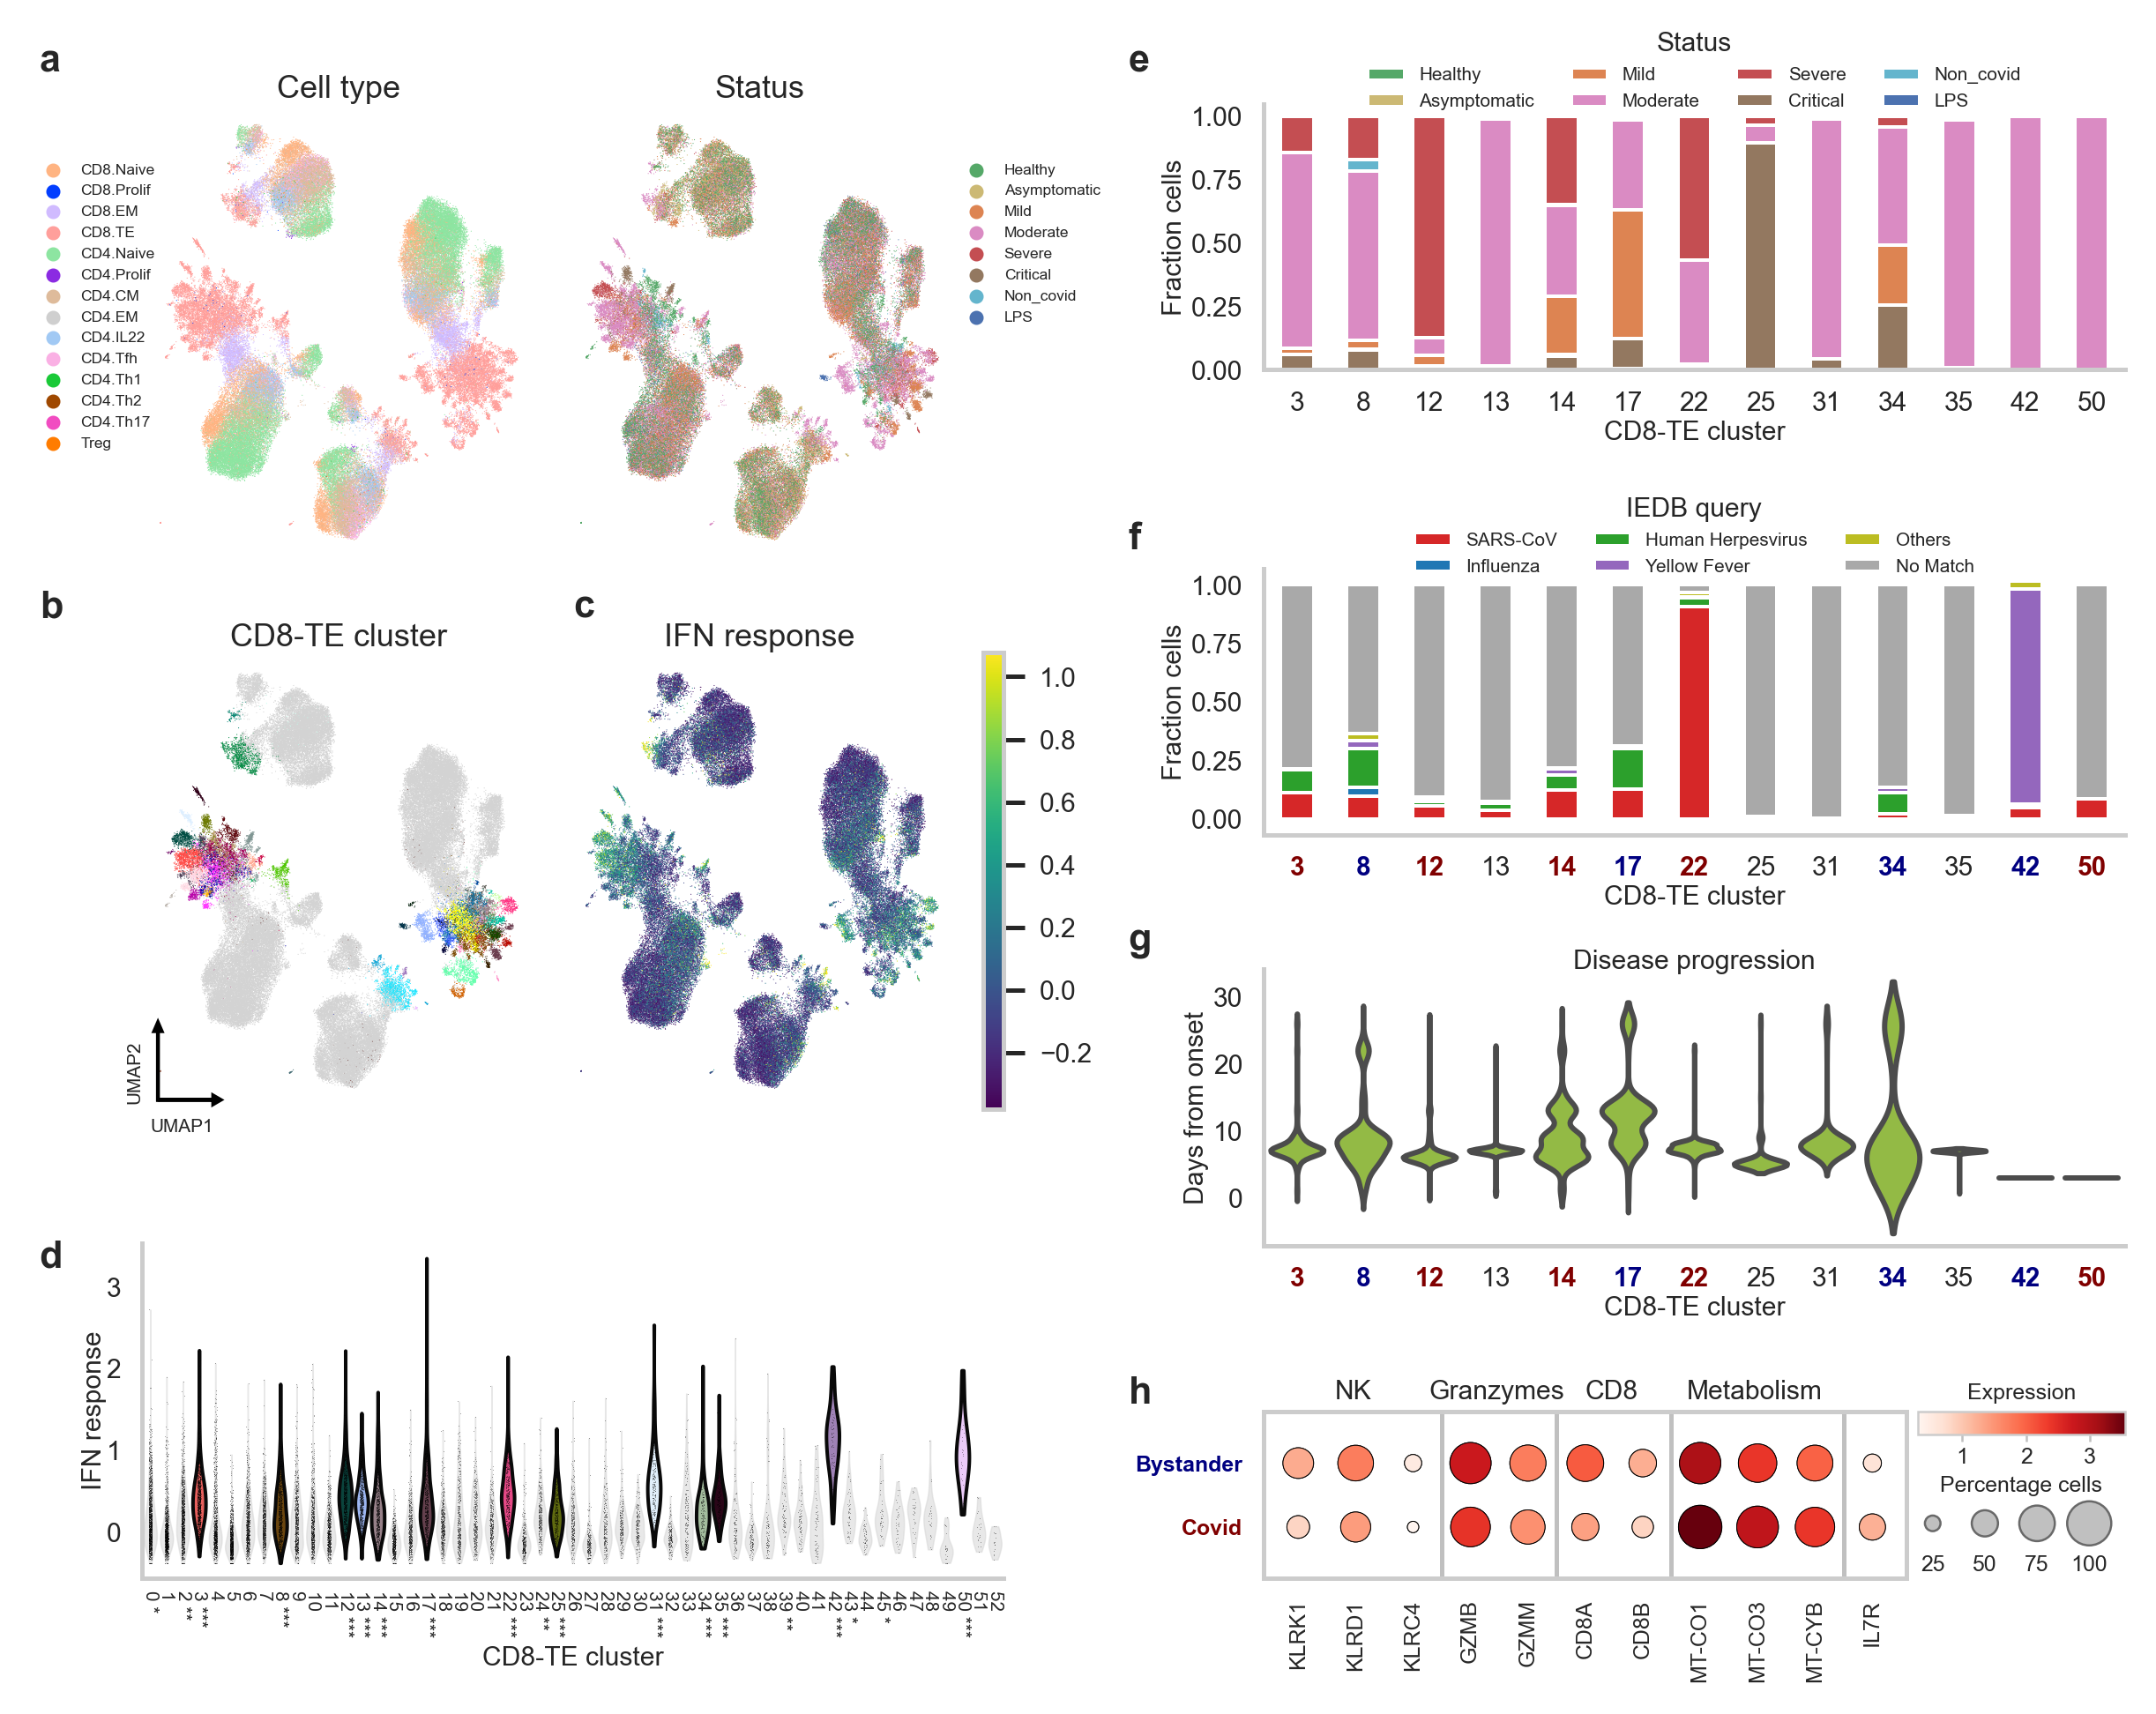

In [35]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.8),
                 dpi=DPI)
gridspecs = {}

#aa c
#aa d   
#b  e  
#   f

# a=UMAPs, b=violin ifn score, c=status, d=db query, e=days from onset, f=degs


gridspecs["gs_abcdef"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    #wspace=0.1,
    #left=0.00,
    #right=1,
    #top=1,
    #bottom=0,
)

gridspecs["gs_ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abcdef"][0],
    nrows=2,
    ncols=1,
    height_ratios=[3, 1],
    width_ratios=[1],
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][0],
    nrows=2,
    ncols=3,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 0.05],
    wspace=0.1
)


gridspecs["gs_cdef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abcdef"][1],
    nrows=2,
    ncols=1,
    height_ratios=[1.2, 1],
    width_ratios=[1],
    #hspace=0.5
)

gridspecs["gs_cd"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cdef"][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.75
)

gridspecs["gs_ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cdef"][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 0.6],
    width_ratios=[1],
    hspace=0.75
)

"""gridspecs["gs_f"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ef"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
)"""

ax_a = {}
for i in range(6):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])


ax_b = fig.add_subplot(gridspecs["gs_ab"][1])

ax_c = fig.add_subplot(gridspecs["gs_cd"][0])
ax_d = fig.add_subplot(gridspecs["gs_cd"][1])
ax_e = fig.add_subplot(gridspecs["gs_ef"][0])

#ax_f = fig.add_subplot(gridspecs["gs_ef"][1])
#ax_f1 = fig.add_subplot(gridspecs["gs_f"][0])
#ax_f2 = fig.add_subplot(gridspecs["gs_f"][1])

plot_umap(adata, 'full_clustering', ax_a[0], xlabel='Cell type', legend='upper left', order=order_ct)
plot_umap(adata, 'Status_on_day_collection_summary', ax_a[1], xlabel='Status', legend='upper right', order=order_status)
plot_empty(ax_a[2])

plot_umap(adata, 'leiden_moe_cd8te', ax_a[3], xlabel='CD8-TE cluster')
plot_umap(adata, 'ifn response_score', ax_a[4], xlabel='IFN response')
plot_colorbar(adata, 'ifn response_score', ax_a[5])

plot_umap_axis(ax_a[3], offset=0.05)

cv_clusters = adata.uns['cluster_covid_moe']
by_clusters = adata.uns['cluster_bystander_moe']

plot_violin(adata, 'ifn response_score', ax_b)
plot_stacked_bar(df_status_moe, 'Status', 'Fraction cells',  palette_status, ax_c, legend=True, order=order_status)

plot_stacked_bar(df_disease_moe, 'IEDB query', 'Fraction cells', palette_query, ax_d, legend=True, order=order_disease,
                cv_clusters=cv_clusters, by_clusters=by_clusters)

plot_days(adata, 'days_from_onset_numeric', ax_e,
         cv_clusters=cv_clusters, by_clusters=by_clusters)
#plot_degs('Bystander', ax_f1, left=True)
#plot_degs('Covid', ax_f2)

genes = ['KLRK1', 'KLRD1', 'KLRC4', 
         'GZMB', 'GZMM',
         'CD8A', 'CD8B', 
         'MT-CO1', 'MT-CO3', 'MT-CYB', 
         'IL7R']#, '' 'IL7R', 'GNLY', 'NCR3', 'GZMK']
labels = ['NK', 'Granzymes', 'CD8', 'Metabolism']#, 'tbd']
positions = [[1, 1], [3, 4], [5, 6], [8, 8]]
seperators = [3, 5, 7, 10]
plot_degs_dotplot(gridspecs["gs_ef"][1], genes, labels, positions, seperators, size=100, pos1=2.5, pos2=8.5)


fig.text(0.01, 0.96, 'a', size='x-large', weight='bold')
fig.text(0.01, 0.64, 'b', size='x-large', weight='bold')
fig.text(0.26, 0.64, 'c', size='x-large', weight='bold')
fig.text(0.01, 0.26, 'd', size='x-large', weight='bold')
fig.text(0.52, 0.96, 'e', size='x-large', weight='bold')
fig.text(0.52, 0.68, 'f', size='x-large', weight='bold')
fig.text(0.52, 0.445, 'g', size='x-large', weight='bold')
fig.text(0.52, 0.18, 'h', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/03_haniffa_dp.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/03_haniffa_dp.png',
           dpi=DPI, bbox_inches='tight')

## Supplementary data SXYZ

In [36]:
content = {}

multi_index = []
for group in ['Bystander', 'Covid']:
    idx = np.logical_and(adata.uns['rank_genes_groups_moe']['pvals_adj'][group] <=0.05,
                         adata.uns['rank_genes_groups_moe']['logfoldchanges'][group] >=0.25)
    for info in ['names', 'scores', 'pvals_adj', 'logfoldchanges']:
        content[f'{group}_{info}'] = adata.uns['rank_genes_groups_moe'][info][group][idx].tolist()
        
        info_tmp = info if info!='names' else 'genes'
        multi_index.append((group, info_tmp))

max_len = max([len(col) for col in content.values()])
for k, v in content.items():
    content[k] = v + [''] * (max_len-len(v))

multi_index = pd.MultiIndex.from_tuples(multi_index)
        
df_gene_ranking = pd.DataFrame(data=content)
df_gene_ranking = pd.DataFrame(df_gene_ranking.values, columns=multi_index)
df_gene_ranking.to_csv('../results/fig02_haniffa_degs.csv')
df_gene_ranking.head()

Bystander                                       Covid                       \
      genes     scores pvals_adj logfoldchanges   genes     scores pvals_adj   
0      CD8A  15.750019       0.0       1.195508  MT-CO1  15.638415       0.0   
1      CTSW  14.021978       0.0       0.728492    IL7R  14.306614       0.0   
2    FCGR3A   13.98312       0.0        1.35858  MT-ND3  12.395987       0.0   
3     KLRK1  13.253731       0.0       0.999367   KLRB1  12.393647       0.0   
4      CD8B  10.941898       0.0       0.915486  MT-CO3  12.325425       0.0   

                  
  logfoldchanges  
0        0.75247  
1       1.367852  
2       0.960725  
3        1.95663  
4       0.704375

## Supplementary Figure 1

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\2079150602.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((x, y), width_element, group, edgecolor='white', color=colors[i][name])
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\2079150602.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = PathPatch(
C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


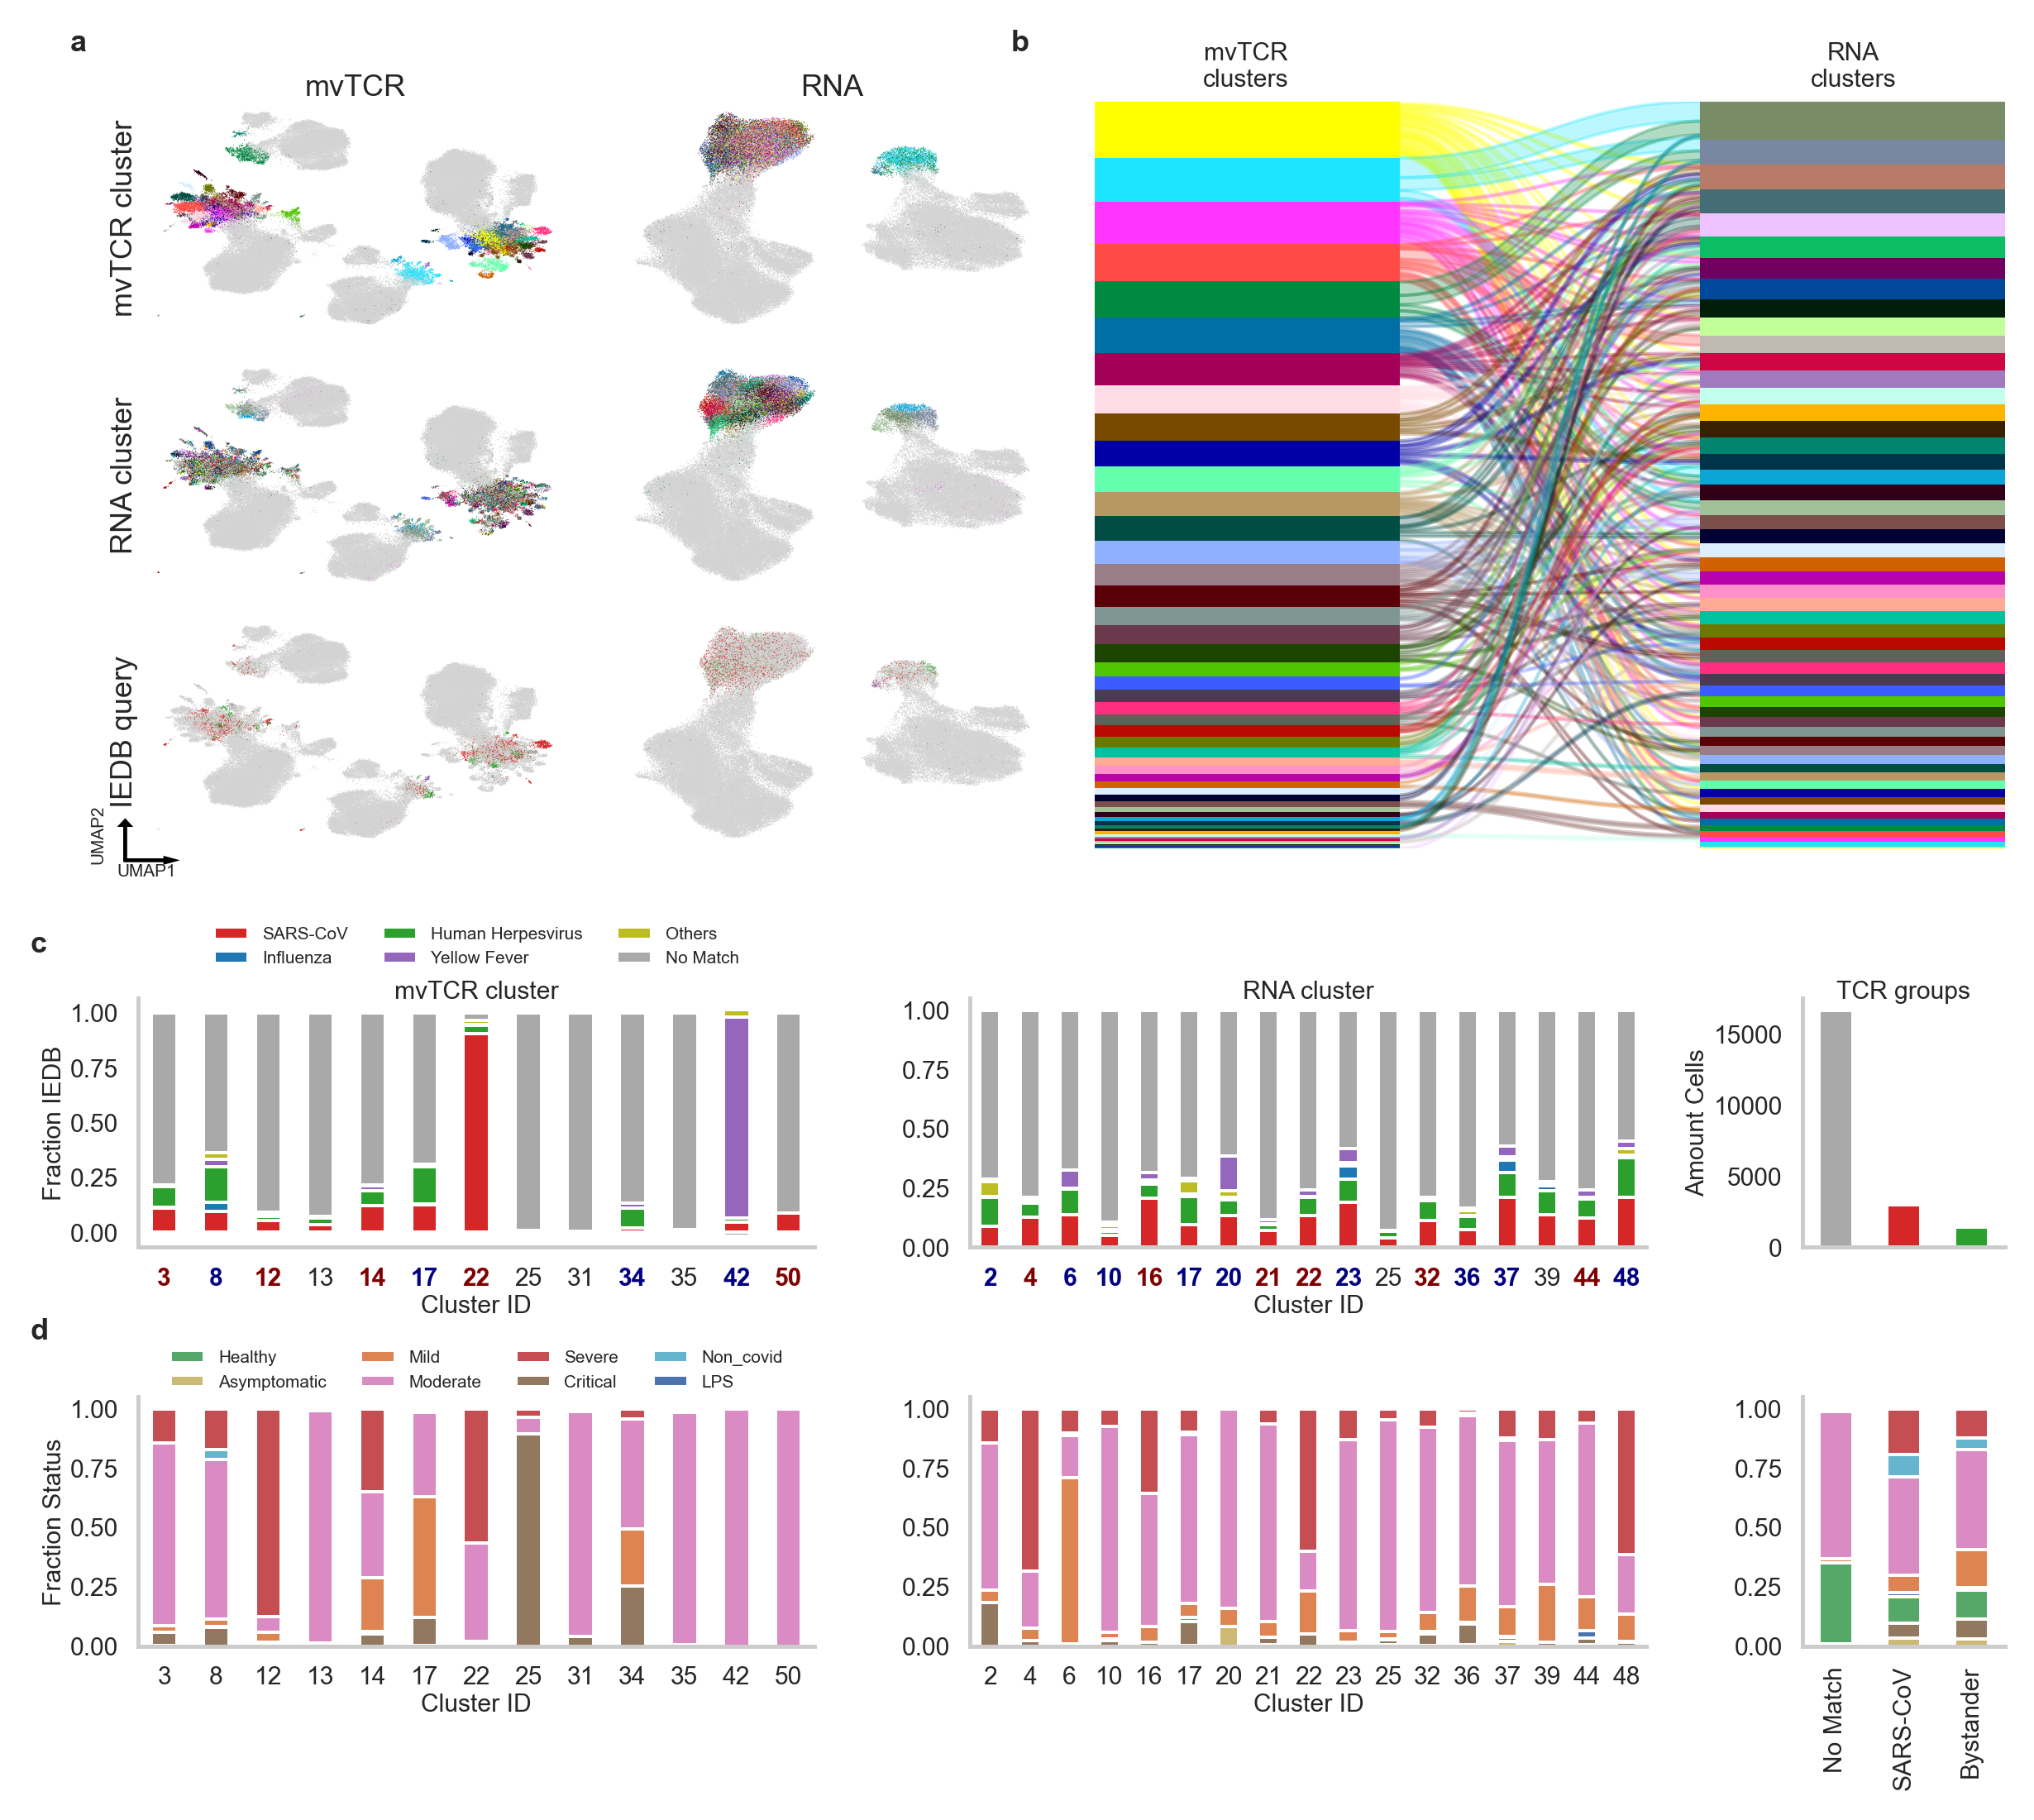

In [82]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.9),
                 dpi=DPI)
gridspecs = {}

# aaaa bbb
# aaaa bbb
# cccccccc
# dddddddd

gridspecs["gs_a-d"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=3,
    ncols=1,
    height_ratios=[3, 1, 1],
    width_ratios=[1],
)

gridspecs["gs_ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-d"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.05
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][0],
    nrows=3,
    ncols=2,
    height_ratios=[1, 1, 1],
    width_ratios=[1, 1],
    wspace=0.1,
    hspace=0.1
)

gridspecs["gs_c"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-d"][1],
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 0.3],
    wspace=0.3
)

gridspecs["gs_d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-d"][2],
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 0.3],
    wspace=0.3
)

ax_a = {}
for i in range(6):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])


plot_umap(adata, 'leiden_moe_cd8te', ax_a[0], ylabel='mvTCR cluster', embedding='moe', xlabel='mvTCR')
plot_umap(adata, 'leiden_rna_cd8te', ax_a[2], ylabel='RNA cluster', embedding='moe')
plot_umap(adata, 'Specificity_IEDB', ax_a[4], ylabel='IEDB query', embedding='moe')

plot_umap(adata, 'leiden_moe_cd8te', ax_a[1], embedding='rna', xlabel='RNA')
plot_umap(adata, 'leiden_rna_cd8te', ax_a[3], embedding='rna')
plot_umap(adata, 'Specificity_IEDB', ax_a[5], embedding='rna')

plot_umap_axis(ax_a[4], offset=0.12, xscale=0.7)


ax_b = fig.add_subplot(gridspecs["gs_ab"][1])
plot_sankey(df_sankey, ['leiden_moe_cd8te', 'leiden_rna_cd8te'], ['mvTCR\nclusters', 'RNA\nclusters'], 
            [colors_moe, colors_rna], 
            ax_b)

ax_c = {}
for i in range(3):
    ax_c[i] = fig.add_subplot(gridspecs["gs_c"][i])

cv_clusters = adata.uns['cluster_covid_moe']
by_clusters = adata.uns['cluster_bystander_moe']
plot_stacked_bar(df_disease_moe, 'mvTCR cluster', 'Fraction IEDB', palette_query, ax_c[0], order=order_disease,
                 legend='top', xlabel='Cluster ID',
                 cv_clusters=adata.uns['cluster_covid_moe'], by_clusters=adata.uns['cluster_bystander_moe'])  
plot_stacked_bar(df_disease_rna, 'RNA cluster', '', palette_query, ax_c[1], order=order_disease, xlabel='Cluster ID',
                 cv_clusters=adata.uns['cluster_covid_rna'], by_clusters=adata.uns['cluster_bystander_rna'])
plot_stacked_bar(df_disease_tcr, 'TCR groups', 'Amount Cells', palette_query, ax_c[2], order=order_disease, 
                 cv_clusters=adata.uns['cluster_covid_moe'], by_clusters=adata.uns['cluster_bystander_moe'], 
                 norm=False, xlabel=False)
 
ax_d = {}
for i in range(3):
    ax_d[i] = fig.add_subplot(gridspecs["gs_d"][i])
    
plot_stacked_bar(df_status_moe, None, 'Fraction Status',  palette_status, ax_d[0], order=order_status, 
                 xlabel='Cluster ID', legend='top')
plot_stacked_bar(df_status_rna, None, '',  palette_status, ax_d[1], order=order_status, xlabel='Cluster ID')
plot_stacked_bar(df_status_tcr, None, '',  palette_status, ax_d[2], order=order_status, xlabel='Group')

fig.text(0.02, 0.98, 'a', size='large', weight='bold')
fig.text(0.49, 0.98, 'b', size='large', weight='bold')
fig.text(0.0, 0.48, 'c', size='large', weight='bold')
fig.text(0.0, 0.265, 'd', size='large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/supp_haniffa_clusters.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/supp_haniffa_clusters.png',
           dpi=DPI, bbox_inches='tight')

## Suppl 2

In [38]:
from scipy.stats import ttest_ind
def get_p_values(df_perf, baselines):
    dfs = []
    
    for baseline in baselines:
        pvals = []
        models = []
        metrics = []
        for metric in df_perf['metric'].unique():
            df_tmp = df_perf[df_perf['metric']==metric]        
            df_left = df_tmp[df_tmp['model']==baseline].copy()
            x_left = df_left['score'].values
            
            for model in df_perf['model'].unique():
                df_right = df_tmp[df_tmp['model']==model].copy()
                x_right = df_right['score'].values
                
                p = ttest_ind(x_left, x_right, alternative='less' if metric!='Days-std' else 'greater')[1]
                
                pvals.append(p)
                models.append(model)
                metrics.append(metric)
        df = pd.DataFrame({'model': models, 'metric': metrics, baseline: pvals})
        dfs.append(df)
    if len(dfs) > 1:
        return  pd.merge(*dfs, on=['model', 'metric'], how='left')
    return dfs[0]

p_values_comp = get_p_values(df_comp[df_comp['model']!='full'], baselines=['RNA', 'TCR'])

In [39]:
def p_2_sign(val):
    if val == -99:
        return ''
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    else:
        return ''

In [40]:
cp = sb.color_palette('deep')
grays = sb.color_palette('Greys', n_colors=5)

palette = {
    'mvTCR': cp[1],
    'RNA': grays[0],  
    'TCR': grays[1],
    'Bystander': color_bystander_clusters,
    'Covid': color_covid_clusters
}

In [41]:
model_order = ['mvTCR', 'RNA', 'TCR']
def plot_boxplot(data, p_values, ax, ylabel='Specificity'):
    data_tmp = data[data['model']!='full'].copy()
    data_tmp['model'] = data_tmp['model'].astype(str)
    plot = sb.boxplot(data=data_tmp, x='model', y='score',
                      hue_order=model_order,
                      palette=palette,
                      fliersize=3, linewidth=0.75,
                      #capsize=.2, errwidth=0.75,
                      ax=ax)
    y_rdm = data[data['model']=='full']['score'].values[0]
    ax.axhline(y_rdm, linestyle='--', color='black')

    ax.set_ylabel(ylabel, labelpad=0)
    ax.set_xlabel(None)
    ax.tick_params('y', pad=-3)
        
    y_pos = 1.03
    
    met = data_tmp['metric'].unique()[0]
    if p_values is not None:
        baseline_cols = [el for el in p_values.columns if el not in ['model', 'metric']]

        for i, mod in enumerate(data_tmp['model'].unique()):
            p_signs = []
            p_tmp = p_values[(p_values['metric']==met) & (p_values['model']==mod)]
            for baseline in baseline_cols:
                p = p_tmp[baseline].values
                p_signs.append(p_2_sign(p))
            p_signs = '\n'.join(p_signs)

            x_pos = i #+ (models.index(mod)-len(models)/2+0.5)*bar_width# - len(models)//2*bar_width 
            ax.text(x_pos, y_pos, p_signs, size='medium', #weight='bold', 
                    linespacing=0.5, transform=ax.get_xaxis_transform(),
                    verticalalignment='center', horizontalalignment='center')    

        x_pos = -0.3
        ax.text(x_pos, y_pos+0.1, 
                '\n'.join(baseline_cols), size='small', verticalalignment='top', 
                horizontalalignment='center', transform=ax.get_xaxis_transform())
    ax.grid(False)
    sb.despine(ax=ax)
    

In [42]:
df_mvtcr_tcr = adata.uns['deg_overlap']
cols = [el for el in df_mvtcr_tcr.columns if ('mvTCR' in el) or ('tcr' in el)]
df_mvtcr_tcr = df_mvtcr_tcr.loc[cols, cols]
df_mvtcr_tcr

,mvTCR_covid,tcr_covid,mvTCR_bystander,tcr_bystander
mvTCR_covid,56,0,0,7
tcr_covid,0,16,8,0
mvTCR_bystander,0,8,95,0
tcr_bystander,7,0,0,19


In [43]:
df_mvtcr_rna = adata.uns['deg_overlap']
cols = [el for el in df_mvtcr_rna.columns if ('mvTCR' in el) or ('rna' in el)]
df_mvtcr_rna = df_mvtcr_rna.loc[cols, cols]
df_mvtcr_rna

,mvTCR_covid,rna_covid,mvTCR_bystander,rna_bystander
mvTCR_covid,56,12,0,13
rna_covid,12,152,19,0
mvTCR_bystander,0,19,95,20
rna_bystander,13,0,20,156


In [44]:
def plot_deg_overlap(df_ven, title, ax):
    
    sb.heatmap(data=df_ven, annot=True, cmap='Greens', ax=ax, fmt='g')
    model = [el if el == 'mvTCR' else el.upper() for el in df_ven.index.str.split('_').str[0]]
    function = [el.capitalize() for el in  df_ven.index.str.split('_').str[1]]

    for j, anno in enumerate([model, function]):
        for i, label in enumerate(anno):
            color = palette[label]
            ax.add_patch(plt.Rectangle(xy=(-0.05*(2-j), i), width=0.05, height=1, color=color, lw=0,
                                       transform=ax.get_yaxis_transform(), clip_on=False))
            ax.add_patch(plt.Rectangle(xy=(i, -0.1*(2-j)), width=1, height=0.1, color=color, lw=0,
                                       transform=ax.get_xaxis_transform(), clip_on=False))
            
    ylabels = [f'{m}\n{f}' for m, f in zip(model, function)]
    ax.set_yticklabels(ylabels)
    ax.tick_params(axis='y', which='major', pad=12)
    
    ax.set_xticklabels([])
    ax.set_title(title)

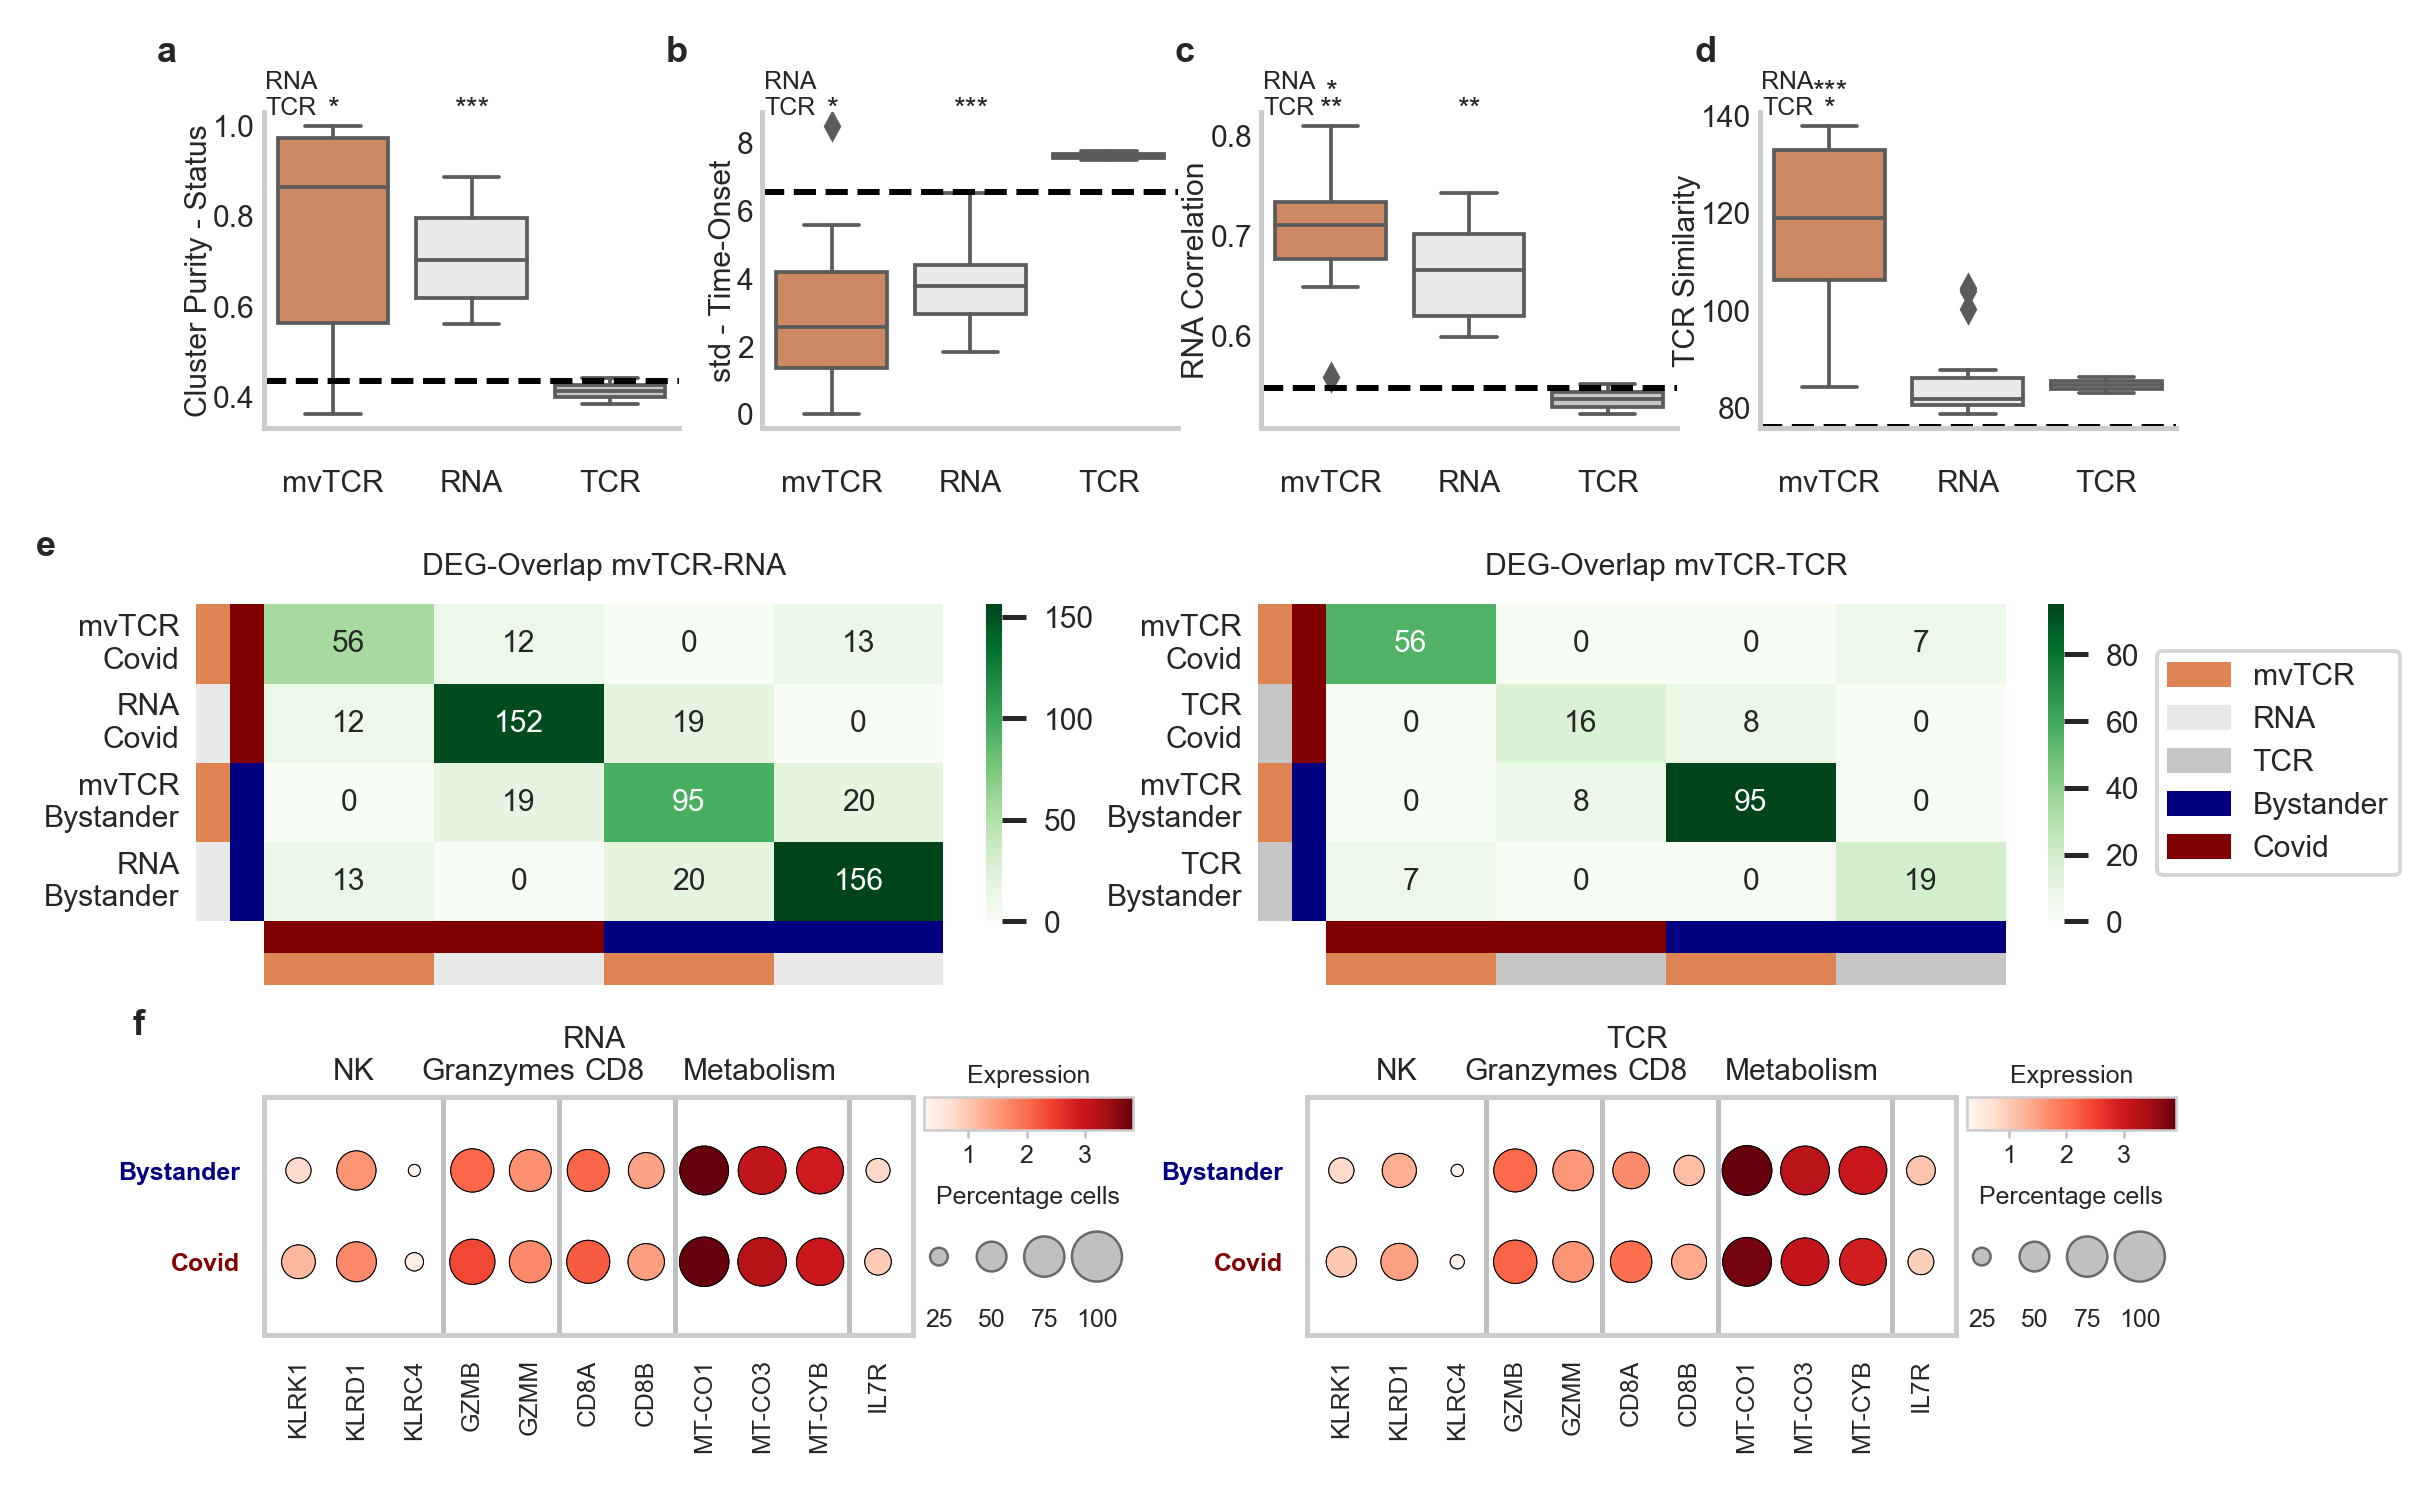

In [45]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.6),
                 dpi=DPI)
gridspecs = {}


gridspecs["gs_a-f"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=3,
    ncols=1,
    height_ratios=[1, 1, 0.75],
    width_ratios=[1],
)

gridspecs["gs_a-d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-f"][0],
    nrows=1,
    ncols=4,
    height_ratios=[1],
    width_ratios=[1, 1, 1, 1],
    #wspace=0.05
)

gridspecs["gs_ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-f"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)

gridspecs["gs_f"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-f"][2],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
)

ax_a = fig.add_subplot(gridspecs["gs_a-d"][0])
ax_b = fig.add_subplot(gridspecs["gs_a-d"][1])
ax_c = fig.add_subplot(gridspecs["gs_a-d"][2])
ax_d = fig.add_subplot(gridspecs["gs_a-d"][3])

ax_e1 = fig.add_subplot(gridspecs["gs_ef"][0])
ax_e2 = fig.add_subplot(gridspecs["gs_ef"][1])

plot_boxplot(df_comp[df_comp['metric']=='RNA-correlation'], p_values_comp, ax_c, ylabel='RNA Correlation')
plot_boxplot(df_comp[df_comp['metric']=='TCR-Similarity'], p_values_comp, ax_d, ylabel='TCR Similarity')
plot_boxplot(df_comp[df_comp['metric']=='Status-purity'], p_values_comp, ax_a, ylabel='Cluster Purity - Status')
plot_boxplot(df_comp[df_comp['metric']=='Days-std'], p_values_comp, ax_b, ylabel='std - Time-Onset')

plot_deg_overlap(df_mvtcr_rna, 'DEG-Overlap mvTCR-RNA', ax_e1)
plot_deg_overlap(df_mvtcr_tcr, 'DEG-Overlap mvTCR-TCR', ax_e2)

genes = ['KLRK1', 'KLRD1', 'KLRC4', 
         'GZMB', 'GZMM',
         'CD8A', 'CD8B', 
         'MT-CO1', 'MT-CO3', 'MT-CYB', 
         'IL7R']#, '' 'IL7R', 'GNLY', 'NCR3', 'GZMK']
labels = ['NK', 'Granzymes', 'CD8', 'Metabolism']#, 'tbd']
positions = [[1, 1], [3, 4], [5, 6], [8, 8]]
seperators = [3, 5, 7, 10]
plot_degs_dotplot(gridspecs["gs_f"][0], genes, labels, positions, seperators, size=100, pos1=2.5, pos2=8.5, 
                  groups='cd8te_assignment_rna', title='RNA')
plot_degs_dotplot(gridspecs["gs_f"][1], genes, labels, positions, seperators, size=100, pos1=2.5, pos2=8.5, 
                  groups='cd8te_assignment_tcr', title='TCR')


handles = [mpl.patches.Patch(color=c, label=l) for l, c in palette.items()]
ax_e2.legend(handles=handles, loc='center left', bbox_to_anchor=(1.2, 0.5))


fig.text(0.06, 0.98, 'a', size='large', weight='bold')
fig.text(0.27, 0.98, 'b', size='large', weight='bold')
fig.text(0.48, 0.98, 'c', size='large', weight='bold')
fig.text(0.695, 0.98, 'd', size='large', weight='bold')
fig.text(0.01, 0.64, 'e', size='large', weight='bold')
fig.text(0.05, 0.31, 'f', size='large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/suppl_haniffa_results.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_haniffa_results.png',
           dpi=DPI, bbox_inches='tight')

In [46]:
p_values_comp

,model,metric,RNA,TCR
0,mvTCR,RNA-correlation,2.615773e-02,0.002068
1,RNA,RNA-correlation,5.000000e-01,0.001036
2,TCR,RNA-correlation,9.989639e-01,0.500000
3,mvTCR,Days-std,9.098917e-02,0.011227
4,RNA,Days-std,5.000000e-01,0.000449
5,TCR,Days-std,9.995514e-01,0.500000
6,mvTCR,TCR-Similarity,9.694998e-07,0.018843
7,RNA,TCR-Similarity,5.000000e-01,0.431574
8,TCR,TCR-Similarity,5.684262e-01,0.500000
9,mvTCR,Status-purity,2.229001e-01,0.027903


In [47]:
genes_by = [el for el in genes if el in adata.uns['genes_bystander_moe']]
genes_cov = [el for el in genes if el in adata.uns['genes_covid_moe']]
print(genes_cov)
print(genes_by)

['MT-CO1', 'MT-CO3', 'MT-CYB', 'IL7R']
['KLRK1', 'KLRD1', 'KLRC4', 'GZMB', 'GZMM', 'CD8A', 'CD8B']


In [48]:
print([el for el in genes_by if el in adata.uns['genes_bystander_rna']])
print([el for el in genes_cov if el in adata.uns['genes_covid_rna']])
print([el for el in genes_by if el in adata.uns['genes_covid_rna']])
print([el for el in genes_cov if el in adata.uns['genes_bystander_rna']])

[]
['IL7R']
['KLRK1', 'KLRC4', 'GZMB']
[]


In [49]:
print([el for el in genes_by if el in adata.uns['genes_bystander_tcr']])
print([el for el in genes_cov if el in adata.uns['genes_covid_tcr']])
print([el for el in genes_by if el in adata.uns['genes_covid_tcr']])
print([el for el in genes_cov if el in adata.uns['genes_bystander_tcr']])

[]
[]
['KLRK1', 'KLRD1', 'CD8A', 'CD8B']
['IL7R']


In [50]:
p_values_comp

,model,metric,RNA,TCR
0,mvTCR,RNA-correlation,2.615773e-02,0.002068
1,RNA,RNA-correlation,5.000000e-01,0.001036
2,TCR,RNA-correlation,9.989639e-01,0.500000
3,mvTCR,Days-std,9.098917e-02,0.011227
4,RNA,Days-std,5.000000e-01,0.000449
5,TCR,Days-std,9.995514e-01,0.500000
6,mvTCR,TCR-Similarity,9.694998e-07,0.018843
7,RNA,TCR-Similarity,5.000000e-01,0.431574
8,TCR,TCR-Similarity,5.684262e-01,0.500000
9,mvTCR,Status-purity,2.229001e-01,0.027903


In [51]:
p_values_comp

,model,metric,RNA,TCR
0,mvTCR,RNA-correlation,2.615773e-02,0.002068
1,RNA,RNA-correlation,5.000000e-01,0.001036
2,TCR,RNA-correlation,9.989639e-01,0.500000
3,mvTCR,Days-std,9.098917e-02,0.011227
4,RNA,Days-std,5.000000e-01,0.000449
5,TCR,Days-std,9.995514e-01,0.500000
6,mvTCR,TCR-Similarity,9.694998e-07,0.018843
7,RNA,TCR-Similarity,5.000000e-01,0.431574
8,TCR,TCR-Similarity,5.684262e-01,0.500000
9,mvTCR,Status-purity,2.229001e-01,0.027903


In [52]:
df_comp.groupby(['metric', 'model'])['score'].mean()

metric           model
Days-std         RNA        3.884688
                 TCR        7.612267
                 full       6.552486
                 mvTCR      2.932960
RNA-correlation  RNA        0.663297
                 TCR        0.536165
                 full       0.547025
                 mvTCR      0.705674
Status-purity    RNA        0.717502
                 TCR        0.411571
                 full       0.433117
                 mvTCR      0.765662
TCR-Similarity   RNA       85.872955
                 TCR       84.783377
                 full      76.210404
                 mvTCR    116.381675
Name: score, dtype: float64

## Stats

In [53]:
react_leiden = adata.uns['moe_reactiveClusters']
len(react_leiden)

13

### Severity classes

In [54]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['Status'].value_counts(normalize=True)

Covid        0.990639
Non_covid    0.006481
Healthy      0.002160
LPS          0.000720
Name: Status, dtype: float64

### Days after Onset Reactive clusters

In [55]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
3      7.670686
8      8.931079
12     6.710145
13     6.978852
14     9.127273
17    12.690702
22     7.428994
25     5.508143
31     8.528497
34     9.725352
35     6.950355
42     3.000000
50     3.000000
Name: days_from_onset_numeric, dtype: float64

In [56]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].mean()

8.138161459273975

In [57]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].std()

4.186608728454209

### Days after Onset Non-Reactive clusters

In [58]:
adata[~adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].mean()

11.702688133910206

In [59]:
adata[~adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].std()

8.833111291518794

### Days after Onset - Covid clusters

In [60]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
3     7.670686
12    6.710145
14    9.127273
22    7.428994
50    3.000000
Name: days_from_onset_numeric, dtype: float64

In [61]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs['days_from_onset_numeric'].mean()

7.68141916605706

In [62]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs['days_from_onset_numeric'].std()

3.2086552868699028

### Days after Onset - Bystander clusters

In [63]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
8      8.931079
17    12.690702
34     9.725352
42     3.000000
Name: days_from_onset_numeric, dtype: float64

In [64]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs['days_from_onset_numeric'].mean()

10.082

In [65]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs['days_from_onset_numeric'].std()

6.001384874644274

###  Days after Onset - Remaining clusters

In [66]:
adata[~adata.obs['leiden_moe_cd8te'].isin(by_clusters) 
      & ~adata.obs['leiden_moe_cd8te'].isin(cv_clusters) 
     ].obs['days_from_onset_numeric'].mean()

11.614780355998775

### Amount cells expressing

In [67]:
adata_cv = adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)]
adata_il7r_cv = adata_cv[adata_cv[:, 'IL7R'].X>0]
len(adata_il7r_cv)/len(adata_cv)

0.3029529711994167

### 

In [68]:
adata.obs['Specificity_IEDB'].value_counts()

nan                  16453
SARS-CoV              2994
Human Herpesvirus     1395
No Match               244
Yellow Fever           155
Others                  26
Influenza                9
Name: Specificity_IEDB, dtype: int64

### NMI between MoE, RNA, and Database Query

In [69]:
from sklearn.metrics import normalized_mutual_info_score

df_tmp = adata[adata.obs['full_clustering']=='CD8.TE'].obs.copy()
nmi_2_rna = normalized_mutual_info_score(df_tmp['leiden_moe_cd8te'].values, 
                                         df_tmp['leiden_rna_cd8te'].values)

df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].astype(str)
df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].fillna('No match')
nmi_2_tcr = normalized_mutual_info_score(df_tmp['leiden_moe_cd8te'].values, 
                                         df_tmp['Specificity_IEDB'].values)
print(f'NMI mvTCR-RNA: {nmi_2_rna}') 
print(f'NMI mvTCR-TCR: {nmi_2_tcr}') 

NMI mvTCR-RNA: 0.3060350258181128
NMI mvTCR-TCR: 0.07521032766456935


### Purity 

In [70]:
react_leiden_moe = adata.uns['moe_reactiveClusters']

df_tmp = adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden_moe)].obs[['leiden_moe_cd8te', 'Specificity_IEDB']]
df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].astype(str)
df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].fillna('No match')
purity_mvtcr_iedb = [el['Specificity_IEDB'].value_counts(normalize=True)[0] 
                     for _, el in df_tmp.groupby('leiden_moe_cd8te')] 
purity_mvtcr_iedb = sum(purity_mvtcr_iedb)/len(purity_mvtcr_iedb)
purity_mvtcr_iedb

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\733336461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].astype(str)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\733336461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].fillna('No match')


0.9038078185091394

In [71]:
react_leiden_rna = adata.uns['rna_reactiveClusters']

df_tmp = adata[adata.obs['leiden_rna_cd8te'].isin(react_leiden_moe)].obs[['leiden_rna_cd8te', 'Specificity_IEDB']]
df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].astype(str)
df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].fillna('No match')
purity_rna_iedb = [el['Specificity_IEDB'].value_counts(normalize=True)[0] 
                     for _, el in df_tmp.groupby('leiden_rna_cd8te')] 
purity_rna_iedb = sum(purity_rna_iedb)/len(purity_rna_iedb)
purity_rna_iedb

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\195819586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].astype(str)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_18072\195819586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Specificity_IEDB'] = df_tmp['Specificity_IEDB'].fillna('No match')


0.7776763158041968

In [72]:
(purity_mvtcr_iedb-purity_rna_iedb)/purity_rna_iedb

0.16219023280207484

In [73]:
adata[adata.obs['leiden_moe_cd8te']=='42'].obs['Specificity_IEDB'].value_counts(normalize=True)

Yellow Fever         0.870968
nan                  0.064516
SARS-CoV             0.048387
Human Herpesvirus    0.016129
Name: Specificity_IEDB, dtype: float64

In [74]:
adata[adata.obs['leiden_moe_cd8te']=='42'].obs['leiden_rna_cd8te'].value_counts()

20    62
Name: leiden_rna_cd8te, dtype: int64

In [75]:
adata[adata.obs['leiden_rna_cd8te']=='20'].obs['Specificity_IEDB'].value_counts()

nan                  299
Yellow Fever          55
SARS-CoV              51
Human Herpesvirus     13
Influenza              2
Name: Specificity_IEDB, dtype: int64

### Cluster comparison

In [76]:
df_comp.groupby(['metric', 'model'])['score'].mean()

metric           model
Days-std         RNA        3.884688
                 TCR        7.612267
                 full       6.552486
                 mvTCR      2.932960
RNA-correlation  RNA        0.663297
                 TCR        0.536165
                 full       0.547025
                 mvTCR      0.705674
Status-purity    RNA        0.717502
                 TCR        0.411571
                 full       0.433117
                 mvTCR      0.765662
TCR-Similarity   RNA       85.872955
                 TCR       84.783377
                 full      76.210404
                 mvTCR    116.381675
Name: score, dtype: float64